# Autoencoder Convolucional SSA - Two layers HH

Continuamos el estudio de SSA a primer orden, entrenamos un modelo convolucional utilizando imágenes de gráficos polares de la sección eficaz - $\sigma(\hat{k}_x, \hat{k}_y)$ -  generados por un modelo de dos capas rugosas bajo la aproximación SSA. Esta vez dejamos fija la geometría incidente. La potencia dispersada se calcula utilizando la aproximación SPM de primer orden, en el canal HH.

In [41]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

import two_rough_layers 

# Parámetros fijos
realizations = 20480

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*pi/.25
d = np.linspace(.5, 1.5, 50)
ep1, ep2 = np.arange(3, 53), np.arange(3, 53)
s1, s2 = np.linspace(.005, .025, 50), np.linspace(.005, .025, 50)
l1, l2 = np.linspace(.05, .25, 50), np.linspace(.05, .25, 50)
theta_i, phi_i = np.linspace(1e-5, 89, 50)*np.pi/180, np.linspace(0, 180, 50)*np.pi/180 

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi / \
    180, np.linspace(0, 360, 30)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigma = np.zeros((realizations, PHI.shape[0], PHI.shape[1]))

# Defino una función para normalizar los datos
def MinMax(tensor):
    return (tensor - np.min(tensor)) / (np.max(tensor) - np.min(tensor))

for i in range(realizations):
    # Genero una tira de indices aleatorios
    index = rng.integers(50, size=9)
    
    # Armo una tupla con los argumentos de S01     
    args = (k0, THETA, PHI,
            theta_i[index[0]], phi_i[index[1]], 
            ep1[index[2]], ep2[index[3]],
            s1[index[4]], l1[index[5]],
            s2[index[6]], l2[index[7]],
            d[index[8]])

    # Calculo la sección eficaz y agrego ruido
    s_O1 = two_rough_layers.suma_O1(*args)

    # h-pol
    s_hh = s_O1[1, 1]
    s_hh_noise = s_hh #+ np.abs(rng.normal(0, .03*np.std(s_hh), size=PHI.shape))

    # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
    # Cuenta cantidad de NaNs
    cond = np.count_nonzero(np.isnan(s_hh_noise))
    if cond == 0:
        sigma[i, :, :] = s_hh_noise
    else:
        raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')

# Chequeo el tamaño de los datos
shape = sigma.shape
print(f'Tamaños de los datos originales: {shape}')

Tamaños de los datos originales: (20480, 30, 30)


Separo en grupos de testeo y entrenamiento.

In [42]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigma))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigma, test_size=.3)

print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (14336, 30, 30)
Tamaño de los datos de testeo: (6144, 30, 30)


In [43]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler().fit(sigma_train.reshape(-1, sigma_train.shape[-1]))

scaled_train = scaler.transform(sigma_train.reshape(-1, sigma_train.shape[-1])).reshape(sigma_train.shape)
scaled_test = scaler.transform(sigma_test.reshape(-1, sigma_test.shape[-1])).reshape(sigma_test.shape)

In [44]:
scaled_train, scaled_test = np.expand_dims(scaled_train, axis=-1), np.expand_dims(scaled_test, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {scaled_train.shape}')
print(f'Tamaño de los datos de testeo: {scaled_test.shape}')

Tamaño de los datos de entrenamiento: (14336, 30, 30, 1)
Tamaño de los datos de testeo: (6144, 30, 30, 1)


### Transformo los datos a DB y miro su distribución

In [ ]:
# Normalizo MinMax
sigma_train = MinMax(sigma_train)
sigma_test = MinMax(sigma_test)

# Como voy a tomar logaritmo, reemplazo los valores que son cero
sigma_train = np.where(sigma_train!=0.0, sigma_train, 1e-7)
sigma_test = np.where(sigma_test!=0.0, sigma_test, 1e-7)

print(np.min(sigma_train))
print(np.min(sigma_test))

1e-07
1e-07


Min(log_sigma_train) = 0.0
Max(log_sigma_train) = 1.0
Min(log_sigma_test) = 0.0
Max(log_sigma_test) = 1.0


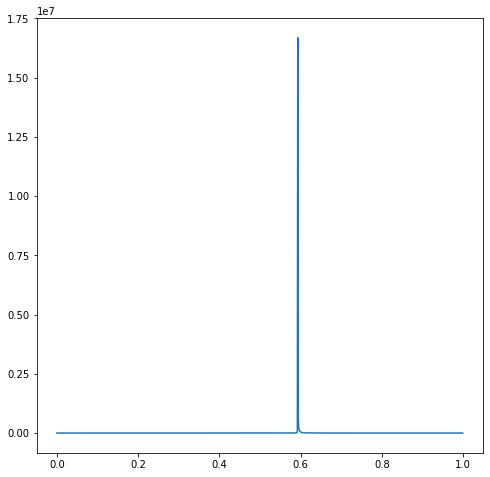

In [ ]:
# Armo un histograma para todo el dataset
n_bins = 1000
count = np.zeros(n_bins)

# Paso a db y normalizo nuevamente los datos de entrenamiento
log_sigma_train = MinMax(10*np.log10(sigma_train))
print((f'Min(log_sigma_train) = {np.min(log_sigma_train)}\n'
f'Max(log_sigma_train) = {np.max(log_sigma_train)}'))

# Paso a db y normalizo nuevamente los datos de testeo
log_sigma_test = MinMax(10*np.log10(sigma_test))
print((f'Min(log_sigma_test) = {np.min(log_sigma_test)}\n'
f'Max(log_sigma_test) = {np.max(log_sigma_test)}'))

# Miramos la distribucion de los nuevos datos de entrenamiento
for img in log_sigma_train:
    hist, bins = np.histogram(img, range=(0,1), bins=n_bins)
    count += hist

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(bins[:-1], count)

## Probemos estandarizando los datos

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Agrego una dimensión extra al final 
sigma_train, sigma_test = np.expand_dims(sigma_train, axis=-1), np.expand_dims(sigma_test, axis=-1)
print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

# Inicio un objeto ImageDataGenerator estandarizado por set
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# Ajusto utilizando el training set
datagen.fit(sigma_train)

# Obtengo los batches para ambos sets
standard_train = datagen.standardize(sigma_train)
#standard_test = datagen.standardize(sigma_test)
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(sigma_test)
standard_test = datagen.standardize(sigma_test)

print(f'Train Mean: {standard_train.mean():.4f} - Train std: {standard_train.std():.4f}' )
print(f'Test Mean: {standard_test.mean():.4f} - Test std: {standard_test.std():.4f}' )

2022-07-14 09:03:58.726888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-14 09:03:58.726922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tamaño de los datos de entrenamiento: (14000, 30, 30, 1)
Tamaño de los datos de testeo: (6000, 30, 30, 1)
Train Mean: -0.0000 - Train std: 0.9999
Test Mean: -0.0000 - Test std: 0.9999


## Visualizo las soluciones generadas

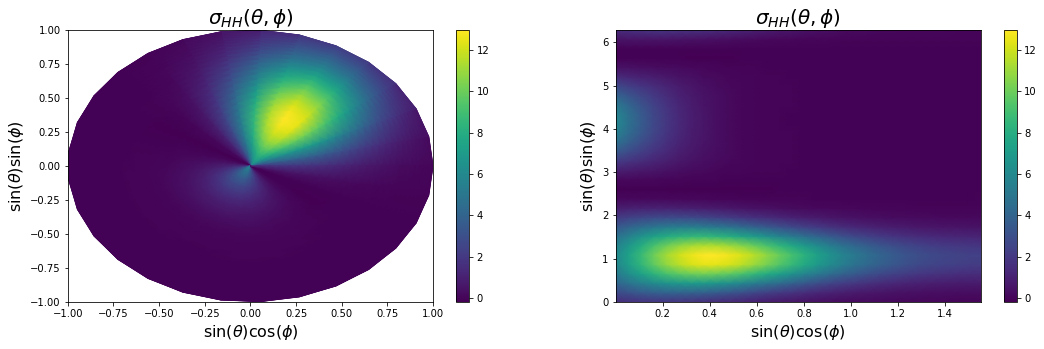

In [45]:
# Elijo una imagen al azar
index = rng.integers(scaled_train.shape[0]) 
img = scaled_train[index, :, :, 0]

fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 2, 1)
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# grafico cartesiano
ax = plt.subplot(1, 2, 2)
c = ax.pcolormesh(THETA, PHI, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)


In [21]:
np.max(scaled_train)

1.0

In [46]:
scaled_train = MinMax(scaled_train)
scaled_test = MinMax(scaled_test)

## Preparo los datos y defino el Autoencoder

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (30, 30, 1)), 
                                            layers.Conv2D(4, (7, 7), strides=1),
                                            layers.LeakyReLU(alpha=0.1),
                                            #layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(8, (5, 5), strides=1),
                                            layers.LeakyReLU(alpha=0.1),
                                            #layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(16, (3, 3), strides=2),
                                            layers.LeakyReLU(alpha=0.1),
                                            #layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Flatten(),
                                            
                                            layers.Dense(units=9*9*16), 
                                            layers.LeakyReLU(alpha=0.1),
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),
                                            
                                            layers.Dense(units=256), 
                                            layers.LeakyReLU(alpha=0.1),
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),

                                            layers.Dense(units=128),
                                            layers.LeakyReLU(alpha=0.1),
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            
                                            layers.Dense(units=64), 
                                            layers.LeakyReLU(alpha=0.1),
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),

                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

                                            layers.Dense(units=64), 
                                            layers.LeakyReLU(alpha=0.1),
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),

                                            layers.Dense(units=128),
                                            layers.LeakyReLU(alpha=0.1),
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),

                                            layers.Dense(units=256), 
                                            layers.LeakyReLU(alpha=0.1),
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),

                                            layers.Dense(units=9*9*16), 
                                            layers.LeakyReLU(alpha=0.1),
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),
                                            
                                            layers.Reshape(target_shape=(9, 9, 16)),
                                            
                                            layers.Conv2DTranspose(16, (4, 4), strides=2),
                                            layers.LeakyReLU(alpha=0.1),
                                            
                                            layers.Conv2DTranspose(8, (5, 5), strides=1),
                                            layers.LeakyReLU(alpha=0.1),

                                            layers.Conv2DTranspose(4, (7, 7), strides=1),
                                            layers.LeakyReLU(alpha=0.1),

                                            layers.Conv2D(1, (3, 3), activation="linear", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [178]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras import layers, losses

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# class ConvAutoencoder(Model):
    
#     def __init__(self, latent_dim):
#         super().__init__()
#         self.latent_dim = latent_dim
#         self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (45,90,1)), 
#                                             layers.Conv2D(4, (7, 7), strides=1, activation = 'relu'),
#                                             layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
#                                             layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
#                                             layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
#                                             layers.Conv2D(8, (3, 3), strides=2, activation = 'relu'),
#                                             layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
#                                             layers.Flatten(),
                                            
#                                             layers.Dense(units=17*39*8, activation='relu'),
#                                             layers.Dropout(.2),

#                                             layers.Dense(units=256, activation='relu'),
#                                             layers.Dropout(.2),

#                                             layers.Dense(units=64, activation='relu'),
#                                             layers.Dropout(.2),

#                                             layers.Dense(latent_dim, activation = 'linear')])
      
        
#         self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

#                                             layers.Dense(units=64, activation='relu'),
#                                             layers.Dropout(.2),
                                            
#                                             layers.Dense(units=256, activation='relu'),
#                                             layers.Dropout(.2),

#                                             layers.Dense(units=17*39*8, activation='relu'),
#                                             layers.Dropout(.2),
                                            
#                                             layers.Reshape(target_shape=(17,39,8)),
                                            
#                                             layers.Conv2DTranspose(8, (3, 4), strides=2, activation="relu"),
                                            
#                                             layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),

#                                             layers.Conv2DTranspose(4, (7, 7), strides=1, activation='relu'),

#                                             layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")])

#     def call(self, X):
#         encoded = self.encoder(X)
#         decoded = self.decoder(encoded)
#         return decoded
  
#     def summary(self):
#         print(self.encoder.summary())
#         print(self.decoder.summary())

In [74]:
autoencoder = ConvAutoencoder(8)
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 4)         200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 8)         808       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 16)          1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 9, 9, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0

In [9]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 1296)              333072    
_________________________________________________________________
reshape (Reshape)            (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 8)        

In [ ]:
# Extiendo las dimensiones de sigma para ingresar al modelo
# sigma_train, sigma_test = np.expand_dims(log_sigma_train, axis=-1), np.expand_dims(log_sigma_test, axis=-1)
# print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
# print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

# Guardo el grupo de testeo para usar más tarde
# folder = os.getcwd().split('/')[:-2]
# file_name = "results/SSA_tl_test_set"

# file_path = os.path.join("/".join(folder), file_name)
# np.save(file_path, sigma_test)

Generemos un optimizador con decay rate

In [159]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay, PiecewiseConstantDecay

# Define size of mini batch and training epochs
epochs = 1000
batch_size = 1024

# Learning rate decay and steps
initial_learning_rate = 0.0005
final_learning_rate = 0.00005
decay_rate = (initial_learning_rate - final_learning_rate)/epochs
decay_steps = int(scaled_train.shape[0] / batch_size) 
total_steps = decay_steps*epochs

# Learning rate schedule
polinomial_learning_rate = PolynomialDecay(
    initial_learning_rate, 
    decay_steps=total_steps, 
    end_learning_rate=final_learning_rate, 
    power=4, 
    staircase=False, 
    name=None
)

step_learning_rate = PiecewiseConstantDecay(
    initial_learning_rate, 
    decay_steps=total_steps, 
    end_learning_rate=final_learning_rate, 
    power=4, 
    #staircase=False, 
    name=None
)

# opt=tf.keras.optimizers.SGD(
#     learning_rate=.4, decay=decay_rate, momentum=0.99, nesterov=False, name="SGD", 
#     clipnorm=1)

# Gradient descent optimizer
opt = tf.keras.optimizers.Adam(
    learning_rate=decay_learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)


Text(0.5, 1.0, 'Learning rate decay during training')

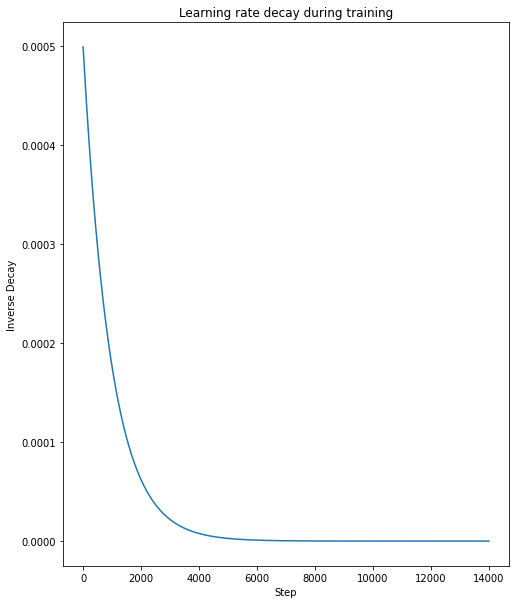

In [160]:
# Evaluo 
total_steps = decay_steps*epochs
decay = [decay_learning_rate(step) for step in range(1, total_steps + 1)]

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
plt.plot(range(1, total_steps + 1), decay)
ax.set_xlabel('Step')
ax.set_ylabel('Inverse Decay')
ax.set_title('Learning rate decay during training')

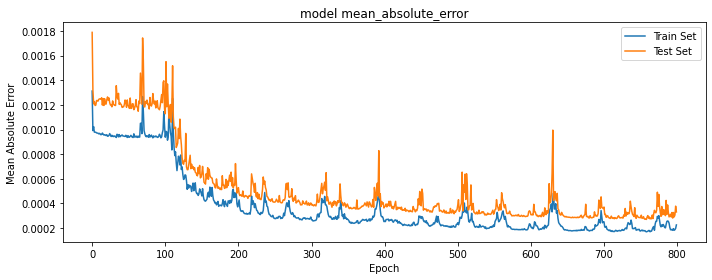

In [75]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = autoencoder.fit(scaled_train, scaled_train,
            epochs = 800,
            batch_size = 1024,
            verbose = 0,
            validation_data=(scaled_test, scaled_test))

# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()


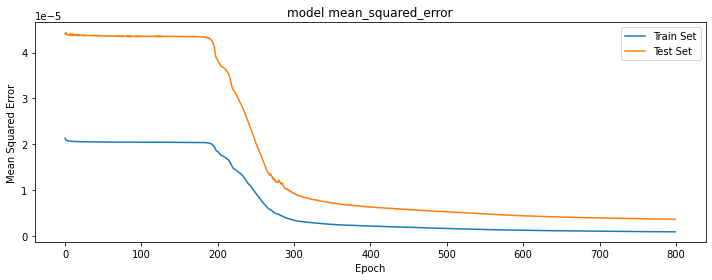

In [152]:
# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()

In [161]:
autoencoder_2 = ConvAutoencoder(10)
autoencoder_2.compile(optimizer=opt, loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = autoencoder_2.fit(scaled_train, scaled_train,
            epochs = 1000,
            batch_size = 1024,
            verbose = 0,
            validation_data=(scaled_test, scaled_test))

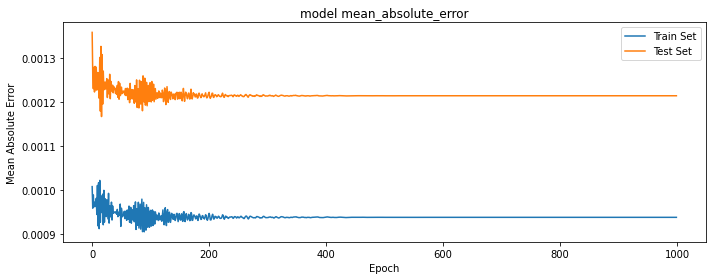

In [162]:
# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()

In [79]:
print(history.history['mean_absolute_error'][790])

0.00020642632443923503


In [9]:
# Guardamos los pesos de la red entrenada
import os
file_name = 'results/weights_lat_3_ssa_two_layer_HH.h5'
folder = os.getcwd().split('/')[:-2]
weights_path = os.path.join('/'.join(folder), file_name)
autoencoder.save_weights(weights_path)

# Visualizamos los resultados 

In [163]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder_2.encoder(scaled_train).numpy()
decoded_imgs = autoencoder_2.decoder(encoded_imgs).numpy()

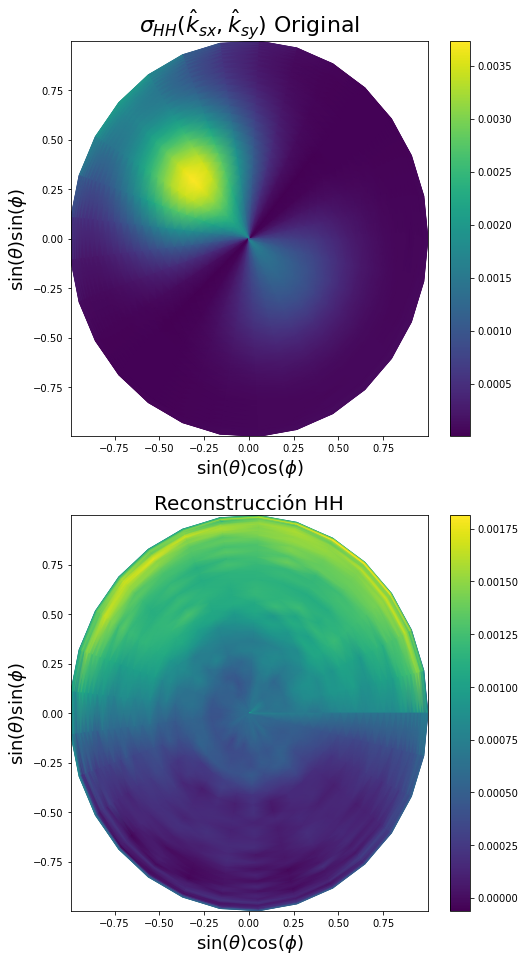

In [164]:


n = 1
pol = {0: "HH", 1: "HV", 2: "VV"}
index = rng.integers(scaled_test.shape[0])

fig = plt.figure(figsize=(8, 16)) 
for i in range(n):
    # Imagen original
    s = scaled_train[index, :, :, 0]
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(f"$\sigma_{{{pol[i]}}}(\hat{{k}}_{{sx}},\hat{{k}}_{{sy}})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, 0]
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title(f"Reconstrucción {pol[i]}", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()


### Pruebo con KFold Cross Validation


In [3]:
from sklearn.model_selection import KFold

def log_mapping(tensor):
    """Mapea la distribución de los datos
    a una distribución uniforme"""
    
    # Hago un primer reescaleado
    scaled_tensor = MinMax(tensor)

    # Paso a una escala en DB
    scaled_tensor = np.where(scaled_tensor!=0.0, scaled_tensor, 1e-7)

    return MinMax(10*np.log10(scaled_tensor))

kfold_cv = KFold(n_splits=5)
mse = list()
mae = list()

for train_fold, test_fold in kfold_cv.split(sigma):
    # Transformo los datos
    sigma_train = log_mapping(sigma[train_fold, :, :])
    sigma_test = log_mapping(sigma[test_fold, :, :])

    # Agrego una dimensión más para ingresar a la red
    sigma_train = np.expand_dims(sigma_train, axis=-1)
    sigma_test = np.expand_dims(sigma_test, axis=-1)
    
    # Entreno el modelo
    autoencoder = ConvAutoencoder(8)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])
                    
    history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 100,
            batch_size = 32,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

    # Guardo los datos 
    mse.append((history.history['mean_absolute_error'],
                history.history['val_mean_absolute_error']))
    mae.append((history.history['mean_squared_error'], 
                history.history['val_mean_squared_error']))
     
    # Elimino el modelo de memoria
    tf.keras.backend.clear_session()
    del autoencoder      

mse = np.vstack(mse)
mae = np.vstack(mae)      

2022-05-17 09:26:11.518343: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 09:26:11.518991: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 09:26:11.519051: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lionelhutz): /proc/driver/nvidia/version does not exist
2022-05-17 09:26:11.519893: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 09:26:12.590631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Opt

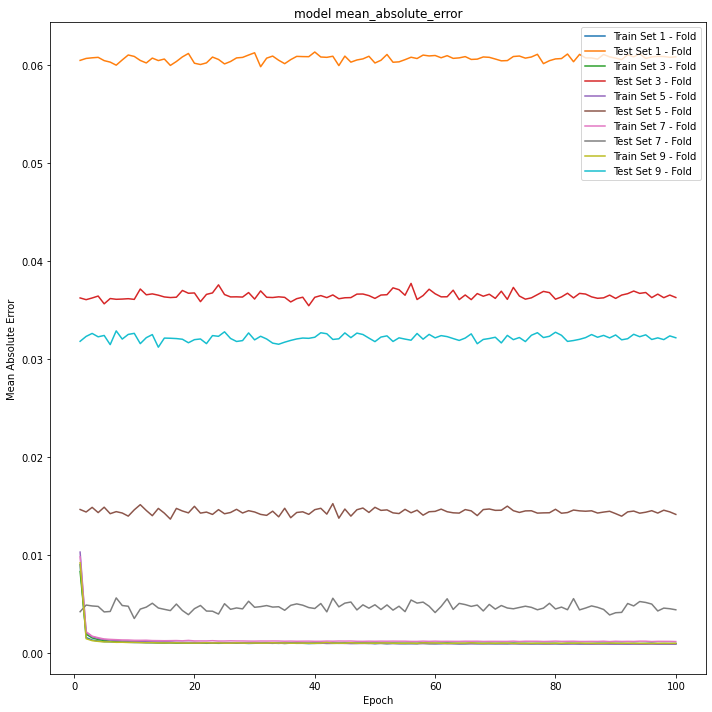

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for idx, error in enumerate(mse):
    f,  = ax.plot(range(1, 101), error)
    if idx%2==0:
        f.set_label(f'Train Set {idx + 1} - Fold')
    else: 
        f.set_label(f'Test Set {idx} - Fold')
    ax.set_title('model mean_absolute_error')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Epoch')
plt.legend()    
plt.tight_layout()    
plt.show()

## Variamos la dimensión del Espacio Latente

In [71]:
# Antes de comenzar limpiamos los pesos del modelo y el grafo de TF
tf.keras.backend.clear_session()
del autoencoder

In [16]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

for lat_dim in range(1, 16):
  autoencoder = ConvAutoencoder(lat_dim)
  autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError(),
                    metrics = ['mean_absolute_error', 'mean_squared_error'])

  # Entreno el modelo
  history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 30,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 10 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))

  tf.keras.backend.clear_session()

In [27]:
error_abs = np.array(history.history['val_mean_absolute_error'])
error_sqr = np.array(history.history['val_mean_squared_error'])

# Valor mínimo del error
min_abs_error[13] = error_abs.min()
min_sqr_error[13] = error_sqr.min()

# Valor promedio del error en los ultimos 10 epochs
avg_abs_error[13] = np.mean(error_abs[-50:])
avg_sqr_error[13] = np.mean(error_sqr[-50:])

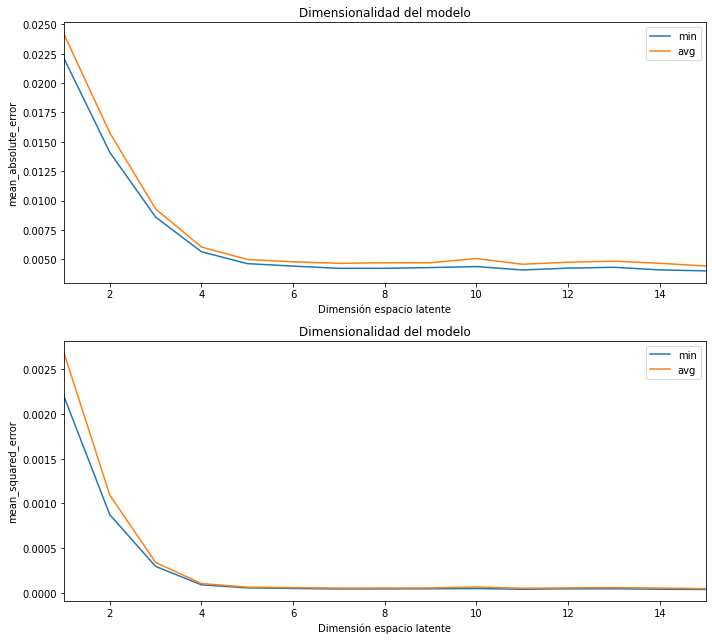

In [28]:
img_name= 'results/costo_SSA_two_layer_2_HH_ngi.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 

In [29]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_SSA_two_layer_HH.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)